# mESC analysis using the object oriented core

We redesigned the core of Cyclum to a more friendly object oriented core. The core is still under active development, but the major functions are already functional.

We still use the mESC dataset. For simplicity we have converted the dataset into TPM.
The original count data is available at ArrayExpress: [E-MTAB-2805](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-2805/). Tools to transform data are also provided and explained in the following sections.

## Import necessary packages

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np
import sklearn as skl

In [3]:
import cyclum.tuning
import cyclum.models
from cyclum import writer


Using TensorFlow backend.


## Read data
Here we have label, so we load both. However, the label is not used until evaluation.

In [19]:
input_file_mask = '/home/shaoheng/Documents/data/mESC/mesc-tpm'

def preprocess(input_file_mask):
    """
    Read in data and perform log transform (log2(x+1)), centering (mean = 1) and scaling (sd = 1).
    """
    tpm = writer.read_df_from_binary(input_file_mask).T
    sttpm = pd.DataFrame(data=skl.preprocessing.scale(np.log2(tpm.values + 1)), index=tpm.index, columns=tpm.columns)
    
    label = pd.read_csv(input_file_mask + '-label.txt', sep="\t", index_col=0).T
    return sttpm, label

sttpm, label = preprocess(input_file_mask)

In [20]:
marker_df = pd.read_table('/home/shaoheng/Documents/cyclum2/data/MGI-cell-cycle-0007049.txt', index_col=False)
marker_df.head()

,MGI Gene/Marker ID,Symbol,Name,Chr,Qualifier,Annotated Term,Context,Proteoform,Evidence,Inferred From,Reference(s)
0,MGI:1922764,1700013H16Rik,RIKEN cDNA 1700013H16 gene,X,NaN,meiotic cell cycle,NaN,NaN,IBA,PTN001064565,J:265628
1,MGI:1920579,1700040F15Rik,RIKEN cDNA 1700040F15 gene,Y,NaN,meiotic cell cycle,NaN,NaN,IBA,PTN001064565,J:265628
2,MGI:1914278,2610002M06Rik,RIKEN cDNA 2610002M06 gene,X,NaN,cell cycle,NaN,NaN,IEA,KW-0131,J:60000
3,MGI:1917941,3830403N18Rik,RIKEN cDNA 3830403N18 gene,X,NaN,meiotic cell cycle,NaN,NaN,IBA,PTN001064565,J:265628
4,MGI:1923051,4930447C04Rik,RIKEN cDNA 4930447C04 gene,12,NaN,meiotic cell cycle,NaN,NaN,IEA,KW-0469,J:60000


In [21]:
sttpm = sttpm.loc[:, marker_df['Symbol'].unique()]
sttpm = sttpm.dropna(1)

sttpm.shape

/home/shaoheng/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(288, 1507)

There is no convention whether cells should be columns or rows. Here we require cells to be rows.

## Set up the model and fit the model

In [22]:
model = cyclum.tuning.CyclumAutoTune(sttpm, max_linear_dims=5, 
                                     epochs=500, rate=2e-4, verbose=100,
                                     encoder_width=[30, 20])

Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch: 100/500, loss:  0.9338, time elapsed:  23.80s, time left:  95.20s
epoch: 200/500, loss:  0.9178, time elapsed:  27.41s, time left:  41.12s
epoch: 300/500, loss:  0.9099, time elapsed:  31.35s, time left:  20.90s
epoch: 400/500, loss:  0.9048, time elapsed:  35.10s, time left:  8.78s
epoch: 500/500, loss:  0.9014, time elapsed:  38.87s, time left:  0.00s
[0.9013684656884935]
[0.848313810035919, 0.831761988555511, 0.8178346012875595, 0.8083970214081979, 0.8002399893376431, 0.79283361370497, 0.7859374676913128]
    1 linear dimensions...
epoch: 100/500, loss:  0.8364, time elapsed:  4.46s, time left:  17.82s
epoch: 200/500, loss:  0.8282, time elapsed:  8.57s, time left:  12.86s
epoch: 300/500, loss:  0.8254, time elapsed:  12.74s, time left:  8.49

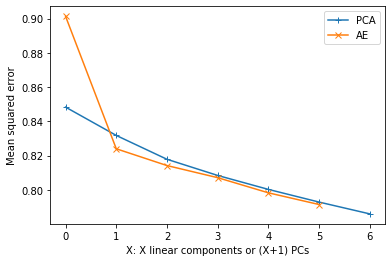

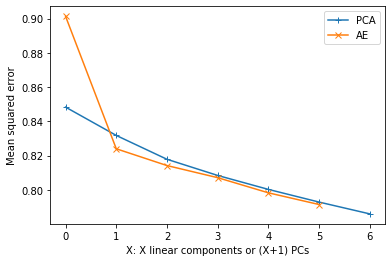

In [23]:
model.show_elbow()

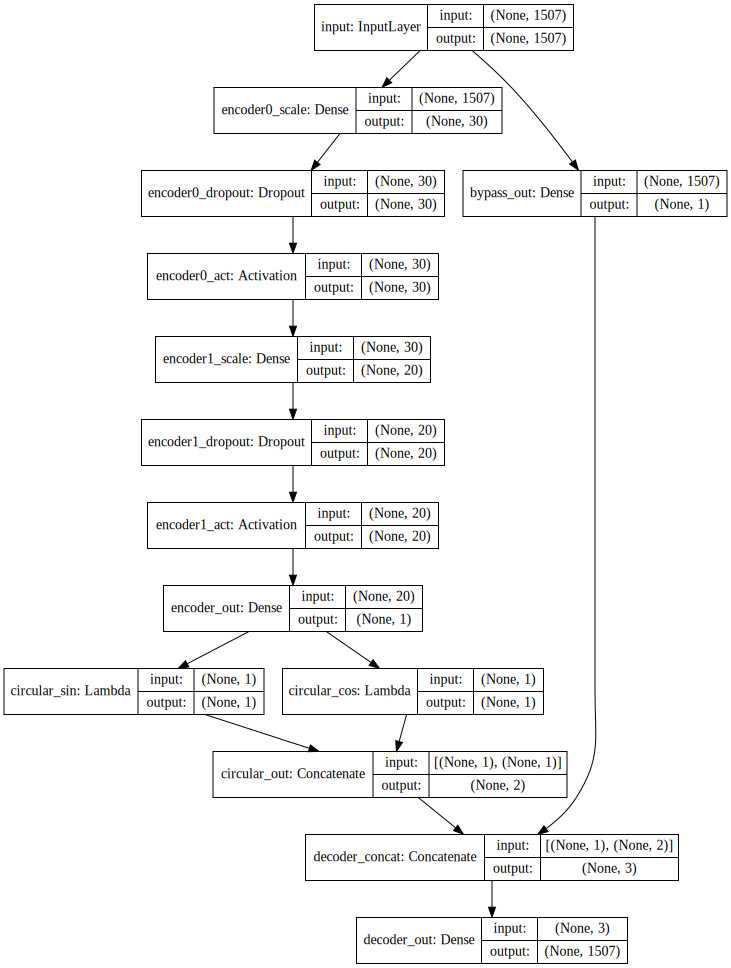

In [24]:
display(model.show_structure())


In [30]:
model.train(sttpm, epochs=1600, verbose=100, rate=2e-4)

epoch: 100/800, loss:  0.8242, time elapsed:  4.56s, time left:  31.89s
epoch: 200/800, loss:  0.8240, time elapsed:  8.49s, time left:  25.48s
epoch: 300/800, loss:  0.8242, time elapsed:  12.33s, time left:  20.54s
epoch: 400/800, loss:  0.8236, time elapsed:  16.40s, time left:  16.40s
epoch: 500/800, loss:  0.8238, time elapsed:  20.30s, time left:  12.18s
epoch: 600/800, loss:  0.8237, time elapsed:  24.12s, time left:  8.04s
epoch: 700/800, loss:  0.8239, time elapsed:  27.90s, time left:  3.99s
epoch: 800/800, loss:  0.8236, time elapsed:  31.91s, time left:  0.00s


In [31]:
pseudotime = model.predict_pseudotime(sttpm)

## Illustrations
We illustrate the results on a circle, to show its circular nature. 
There is virtually no start and end of the circle.
Red, green and blue represents G0/G1, S and G2/M phase respectively.
The inner lines represents single cells. The cells spread across the
The areas outside

In [27]:
import cyclum.illustration

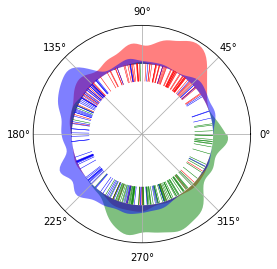

In [32]:
color_map = {'stage': {"g0/g1": "red", "s": "green", "g2/m": "blue"},
                 'subcluster': {"intact": "cyan", "perturbed": "violet"}}
cyclum.illustration.plot_round_distr_color(pseudotime, label['stage'], color_map['stage'])
pass

In [33]:
from cyclum.hdfrw import mat2hdf
mat2hdf(pseudotime, '/home/shaoheng/Documents/data/EMTAB2805/cyclum-marker-only-pseudotime.h5')